### Plot survival curves

Just for BRCA now, as a sanity check.

In [1]:
import os
import pickle as pkl

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns

import mpmp.config as cfg
import mpmp.utilities.data_utilities as du

%load_ext autoreload
%autoreload 2

In [2]:
fold = 0
signal = 'signal'
functions_file = os.path.join(cfg.repo_root,
                              'test_results_5000',
                              'BRCA_survival_{}_fold{}_functions.pkl'.format(
                                  signal, fold))

with open(functions_file, 'rb') as f:
    fns_dict = pkl.load(f)
    
samples = fns_dict['samples']
fns = fns_dict['functions']
print(len(fns))

169


In [3]:
# get clinical info for BRCA samples
# this includes age, subtype, etc.
clinical_df = pd.read_excel(cfg.clinical_data,
                            sheet_name='TCGA-CDR',
                            index_col='bcr_patient_barcode',
                            engine='openpyxl')

clinical_df.drop(labels=['Unnamed: 0'], axis=1, inplace=True)
clinical_df.rename(columns={'age_at_initial_pathologic_diagnosis': 'age'}, inplace=True)

print(clinical_df.shape)
clinical_df.head()

(11160, 32)


,type,age,gender,race,ajcc_pathologic_tumor_stage,clinical_stage,histological_type,histological_grade,initial_pathologic_dx_year,menopause_status,...,residual_tumor,OS,OS.time,DSS,DSS.time,DFI,DFI.time,PFI,PFI.time,Redaction
bcr_patient_barcode,,,,,,,,,,,,,,,,,,,,,
TCGA-OR-A5J1,ACC,58.0,MALE,WHITE,Stage II,[Not Applicable],Adrenocortical carcinoma- Usual Type,[Not Available],2000.0,[Not Available],...,NaN,1.0,1355.0,1.0,1355.0,1.0,754.0,1.0,754.0,NaN
TCGA-OR-A5J2,ACC,44.0,FEMALE,WHITE,Stage IV,[Not Applicable],Adrenocortical carcinoma- Usual Type,[Not Available],2004.0,[Not Available],...,NaN,1.0,1677.0,1.0,1677.0,NaN,NaN,1.0,289.0,NaN
TCGA-OR-A5J3,ACC,23.0,FEMALE,WHITE,Stage III,[Not Applicable],Adrenocortical carcinoma- Usual Type,[Not Available],2008.0,[Not Available],...,NaN,0.0,2091.0,0.0,2091.0,1.0,53.0,1.0,53.0,NaN
TCGA-OR-A5J4,ACC,23.0,FEMALE,WHITE,Stage IV,[Not Applicable],Adrenocortical carcinoma- Usual Type,[Not Available],2000.0,[Not Available],...,NaN,1.0,423.0,1.0,423.0,NaN,NaN,1.0,126.0,NaN
TCGA-OR-A5J5,ACC,30.0,MALE,WHITE,Stage III,[Not Applicable],Adrenocortical carcinoma- Usual Type,[Not Available],2000.0,[Not Available],...,NaN,1.0,365.0,1.0,365.0,NaN,NaN,1.0,50.0,NaN


### Color survival curves by age

Here, we discretize age into quantiles, and color the survival curves by quantile. We'd expect older patients to have shorter/poorer survival in general.

In [4]:
ages = clinical_df.loc[~clinical_df.age.isna(), 'age']
print(ages.isna().sum())
ages.head()

0


bcr_patient_barcode
TCGA-OR-A5J1    58.0
TCGA-OR-A5J2    44.0
TCGA-OR-A5J3    23.0
TCGA-OR-A5J4    23.0
TCGA-OR-A5J5    30.0
Name: age, dtype: float64

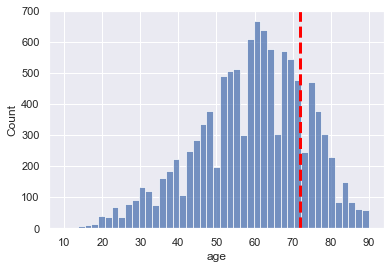

In [5]:
sns.set()
sns.histplot(ages)
qs_age = []
for q in [0.8]:
    q_age = np.quantile(ages, q)
    qs_age.append(q_age)
    plt.gca().axvline(q_age, color='red', linestyle='--', linewidth=3)

In [6]:
age_quantiles = np.digitize(ages.values, qs_age)
ages = pd.DataFrame(ages)
ages['age_quantile'] = age_quantiles
ages.head(n=10)

,age,age_quantile
bcr_patient_barcode,,
TCGA-OR-A5J1,58.0,0
TCGA-OR-A5J2,44.0,0
TCGA-OR-A5J3,23.0,0
TCGA-OR-A5J4,23.0,0
TCGA-OR-A5J5,30.0,0
TCGA-OR-A5J6,29.0,0
TCGA-OR-A5J7,30.0,0
TCGA-OR-A5J8,66.0,0
TCGA-OR-A5J9,22.0,0


Text(0, 0.5, 'Survival probability')

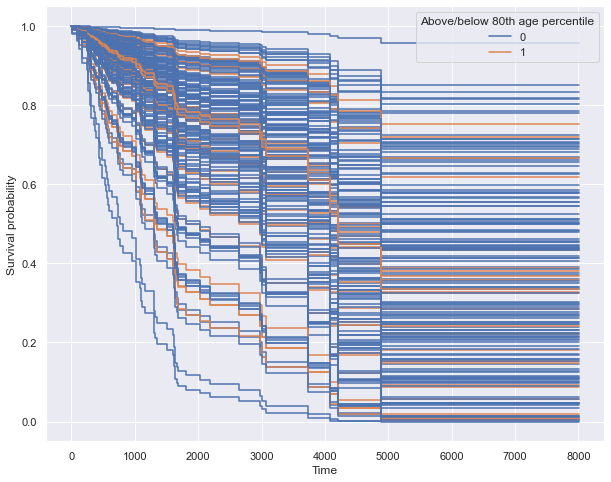

In [7]:
sns.set({'figure.figsize': (10, 8)})

# color by age binned into quantiles
for ix in range(len(fns)):
    fn = fns[ix]
    sample_id = '-'.join(samples[ix].split('-')[:3])
    sample_age_quantile = int(ages.loc[sample_id, 'age_quantile'])
    plt.step(fn.x, fn.y, label=sample_age_quantile,
             color='C{:d}'.format(sample_age_quantile))
    
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), title='Above/below 80th age percentile')
plt.xlabel('Time')
plt.ylabel('Survival probability')

### Color survival curves by stage at diagnosis

Here, we color the survival curves by cancer stage at diagnosis. We'd expect patients diagnosed at a later stage to have shorter/poorer survival in general.

In [8]:
stages = clinical_df.loc[~clinical_df.age.isna(), 'ajcc_pathologic_tumor_stage']
print(stages.unique())
print(stages.isna().sum())
stages.head()

['Stage II' 'Stage IV' 'Stage III' '[Not Available]' 'Stage I' 'Stage X'
 'Stage IIB' 'Stage IA' 'Stage IIIA' 'Stage IIA' 'Stage IIIC' 'Stage IB'
 'Stage IIIB' '[Discrepancy]' 'Stage IVB' 'Stage IVA' 'Stage IIC'
 '[Not Applicable]' '[Unknown]' 'Stage IVC' 'I/II NOS' 'Stage 0' 'IS']
0


bcr_patient_barcode
TCGA-OR-A5J1     Stage II
TCGA-OR-A5J2     Stage IV
TCGA-OR-A5J3    Stage III
TCGA-OR-A5J4     Stage IV
TCGA-OR-A5J5    Stage III
Name: ajcc_pathologic_tumor_stage, dtype: object

Text(0, 0.5, 'Survival probability')

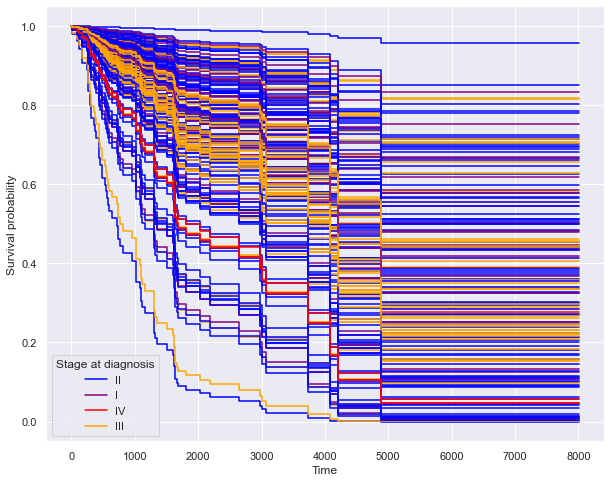

In [9]:
sns.set({'figure.figsize': (10, 8)})

colors = ['purple', 'blue', 'orange', 'red']

# color by stage at diagnosis
for ix in range(len(fns)):
    fn = fns[ix]
    sample_id = '-'.join(samples[ix].split('-')[:3])
    sample_stage = stages.loc[sample_id]
    short_stage = None
    if sample_stage.startswith('Stage III'):
        short_stage = 'III'
        stage_ix = 2
    elif sample_stage.startswith('Stage IV'):
        short_stage = 'IV'
        stage_ix = 3
    elif sample_stage.startswith('Stage II'):
        short_stage = 'II'
        stage_ix = 1
    elif sample_stage.startswith('Stage I'):
        short_stage = 'I'
        stage_ix = 0
    if short_stage is not None:
        plt.step(fn.x, fn.y, drawstyle='steps-pre', color=colors[stage_ix],
                 label=short_stage)
    
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), title='Stage at diagnosis')
plt.xlabel('Time')
plt.ylabel('Survival probability')

### Color survival curves by cancer subtype

Here, we color the survival curves by cancer subtype. Generally, there are pronounced differences in survival between subtypes of any given cancer, although the exact differences depend on the cancer type.

In [10]:
sample_freeze_df = du.load_pancancer_data()[0]
sample_freeze_df.head()

,PATIENT_BARCODE,SAMPLE_BARCODE,DISEASE,SUBTYPE
0,TCGA-OR-A5J1,TCGA-OR-A5J1-01,ACC,Not_Applicable
1,TCGA-OR-A5J2,TCGA-OR-A5J2-01,ACC,Not_Applicable
2,TCGA-OR-A5J3,TCGA-OR-A5J3-01,ACC,Not_Applicable
3,TCGA-OR-A5J5,TCGA-OR-A5J5-01,ACC,Not_Applicable
4,TCGA-OR-A5J6,TCGA-OR-A5J6-01,ACC,Not_Applicable


In [11]:
subtypes = sample_freeze_df[sample_freeze_df.DISEASE == 'BRCA'].SUBTYPE.unique()
subtype_to_ix = {st: ix for ix, st in enumerate(sorted(subtypes))}
print(subtype_to_ix)

{'Basal': 0, 'Her2': 1, 'LumA': 2, 'LumB': 3, 'Normal': 4}


Text(0, 0.5, 'Survival probability')

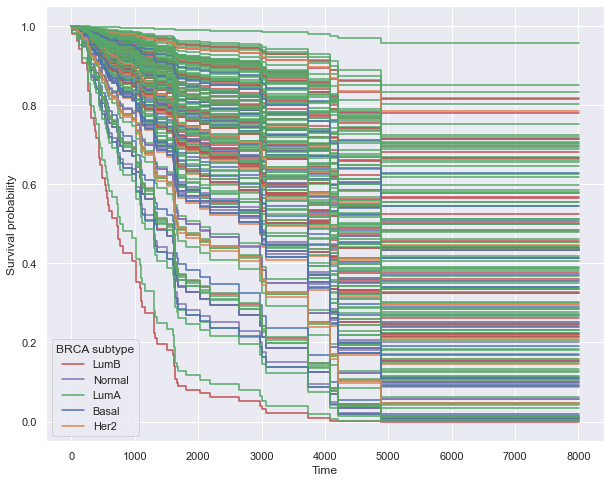

In [12]:
sns.set({'figure.figsize': (10, 8)})

# color by stage at diagnosis
for ix in range(len(fns)):
    fn = fns[ix]
    sample_id = '-'.join(samples[ix].split('-')[:3])
    subtype = (sample_freeze_df
      .loc[sample_freeze_df.PATIENT_BARCODE == sample_id, 'SUBTYPE']
      .values[0]
    )
    plt.step(fn.x, fn.y, label=subtype,
             color=sns.color_palette()[subtype_to_ix[subtype]])
    
handles, labels = plt.gca().get_legend_handles_labels()
by_label = dict(zip(labels, handles))
plt.legend(by_label.values(), by_label.keys(), title='BRCA subtype')
plt.xlabel('Time')
plt.ylabel('Survival probability')